In [8]:
# Import necessary libraries
import pandas
import zipfile
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
import os
from collections import Counter
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2


In [2]:
# Mount Google Drive to access data stored there
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# Define the path to the zipped dataset file on Google Drive
zip_file_path = '/content/drive/MyDrive/malaria_dataset.zip'

# Define the path where the dataset will be extracted
extracted_folder_path = 'content/dataset'

In [4]:
import zipfile

# Extract the contents of the zipped dataset file to the specified folder
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

In [5]:
# List the contents of the extracted folder
print(os.listdir(extracted_folder_path))

# List the contents of train, test, and val folders to ensure they are correct
print(os.listdir(os.path.join(extracted_folder_path, 'train')))
print(os.listdir(os.path.join(extracted_folder_path, 'test')))
print(os.listdir(os.path.join(extracted_folder_path, 'valid')))


['valid', 'README.roboflow.txt', 'test', 'README.dataset.txt', 'train']
['Parasitized', 'Uninfected']
['Parasitized', 'Uninfected']
['Parasitized', 'Uninfected']


In [6]:
# Define paths to train, test, and val directories
train_dir = os.path.join(extracted_folder_path, 'train')
test_dir = os.path.join(extracted_folder_path, 'test')
valid_dir = os.path.join(extracted_folder_path, 'valid')

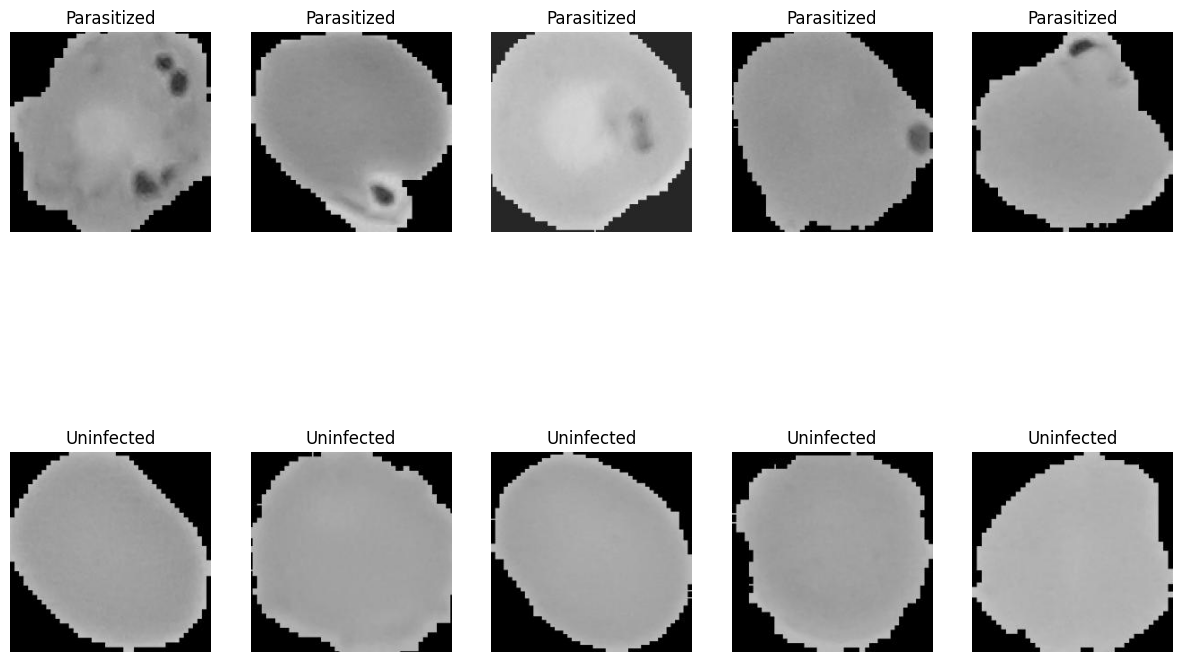

In [7]:
# Function to visualize images from the dataset
def visualize_raw_samples(dataset_dir, class_names, num_images_per_class=5):
    plt.figure(figsize=(15, 10))

    for class_index, class_name in enumerate(class_names):
        class_dir = os.path.join(dataset_dir, class_name)
        image_files = os.listdir(class_dir)[:num_images_per_class]

        for i, image_file in enumerate(image_files):
            image_path = os.path.join(class_dir, image_file)
            image = Image.open(image_path)

            ax = plt.subplot(len(class_names), num_images_per_class, class_index * num_images_per_class + i + 1)
            plt.imshow(image)
            plt.title(class_name)
            plt.axis("off")

# Define class names
class_names = ['Parasitized', 'Uninfected']

# Visualize samples from the training dataset
visualize_raw_samples(train_dir, class_names)

In [9]:
# Function to get class distribution
def get_class_distribution_from_dir(dataset_dir):
    class_counts = Counter()
    for class_name in os.listdir(dataset_dir):
        class_dir = os.path.join(dataset_dir, class_name)
        if os.path.isdir(class_dir):
            num_images = len(os.listdir(class_dir))
            class_counts[class_name] = num_images
    return class_counts

# Get class distributions for the training, validation, and test directories
train_class_distribution = get_class_distribution_from_dir(train_dir)
val_class_distribution = get_class_distribution_from_dir(valid_dir)
test_class_distribution = get_class_distribution_from_dir(test_dir)

# Print out the class distributions
print("Train class distribution:", train_class_distribution)
print("Validation class distribution:", val_class_distribution)
print("Test class distribution:", test_class_distribution)

Train class distribution: Counter({'Uninfected': 6582, 'Parasitized': 6570})
Validation class distribution: Counter({'Parasitized': 629, 'Uninfected': 624})
Test class distribution: Counter({'Uninfected': 317, 'Parasitized': 309})


In [ ]:
# Create an ImageDataGenerator for training with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255.,             # Rescale pixel values to [0, 1]
    horizontal_flip=True,        # Randomly flip images horizontally
    vertical_flip=True,          # Randomly flip images vertically
    rotation_range=40,           # Randomly rotate images by up to 40 degrees
    shear_range=0.2,             # Randomly shear images
    width_shift_range=0.4,       # Randomly shift images horizontally
    height_shift_range=0.4,      # Randomly shift images vertically
    fill_mode='nearest'          # Fill in missing pixels after transformations
)

# Create ImageDataGenerators for validation and test sets (no augmentation, just rescaling)
valid_datagen = ImageDataGenerator(rescale=1.0/255.)
test_datagen = ImageDataGenerator(rescale=1.0/255.)

# Create a data generator for the training set
train_generator = train_datagen.flow_from_directory(
    train_dir,                   # Directory containing training images
    batch_size=32,               # Batch size
    target_size=(224, 224),      # Resize images to 224x224 pixels
    class_mode='binary',         # Binary classification (infected or not)
    shuffle=True,                # Shuffle the data
    seed=42,                     # Seed for reproducibility
    color_mode='grayscale'       # Use grayscale images
)

# Create a data generator for the validation set
valid_generator = valid_datagen.flow_from_directory(
    valid_dir,                   # Directory containing validation images
    batch_size=32,               # Batch size
    target_size=(224, 224),      # Resize images to 224x224 pixels
    class_mode='binary',         # Binary classification (infected or not)
    shuffle=True,                # Shuffle the data
    seed=42,                     # Seed for reproducibility
    color_mode='grayscale'       # Use grayscale images
)

# Create a data generator for the test set
test_generator = test_datagen.flow_from_directory(
    test_dir,                    # Directory containing test images
    batch_size=32,               # Batch size
    target_size=(224, 224),      # Resize images to 224x224 pixels
    class_mode='binary',         # Binary classification (infected or not)
    shuffle=False,               # Do not shuffle the data
    color_mode='grayscale'       # Use grayscale images
)

# Get the class labels from the training generator
class_labels = train_generator.class_indices

# Create a dictionary to map class indices to class names
class_names = {value: key for (key, value) in class_labels.items()}

Found 13152 images belonging to 2 classes.
Found 1253 images belonging to 2 classes.
Found 626 images belonging to 2 classes.


In [ ]:
# Output the class labels and their corresponding class names
class_labels, class_names

({'Parasitized': 0, 'Uninfected': 1}, {0: 'Parasitized', 1: 'Uninfected'})

In [ ]:
# Load the pre-trained MobileNetV2 model
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Modify the first convolutional layer to accept grayscale images by converting to 3 channels
input_layer = Input(shape=(224, 224, 1))
x = tf.keras.layers.Conv2D(3, (3, 3), padding='same')(input_layer)  # Convert grayscale to RGB by duplicating channels
x = base_model(x)

# Add a classifier
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification

# Create the final model
model = Model(inputs=input_layer, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

# Callbacks
filepath = 'best_model.h5'
es = EarlyStopping(monitor='val_loss', verbose=1, mode='min', patience=4)
cp = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
lrr = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.0001)


9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 3)       30        
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                

In [ ]:
# Train the model
history = model.fit(train_generator,
                    validation_data=valid_generator,
                    epochs=20,  # Increase number of epochs if needed
                    callbacks=[es, cp, lrr])

Epoch 1/20
411/411 [==============================] - ETA: 0s - loss: 0.5220 - accuracy: 0.7446
Epoch 1: val_loss improved from inf to 0.36023, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


411/411 [==============================] - 98s 212ms/step - loss: 0.5220 - accuracy: 0.7446 - val_loss: 0.3602 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 2/20
411/411 [==============================] - ETA: 0s - loss: 0.4275 - accuracy: 0.8077
Epoch 2: val_loss did not improve from 0.36023
411/411 [==============================] - 83s 202ms/step - loss: 0.4275 - accuracy: 0.8077 - val_loss: 0.3620 - val_accuracy: 0.8292 - lr: 0.0010
Epoch 3/20
411/411 [==============================] - ETA: 0s - loss: 0.4085 - accuracy: 0.8183
Epoch 3: val_loss improved from 0.36023 to 0.29593, saving model to best_model.h5
411/411 [==============================] - 82s 200ms/step - loss: 0.4085 - accuracy: 0.8183 - val_loss: 0.2959 - val_accuracy: 0.8691 - lr: 0.0010
Epoch 4/20
411/411 [==============================] - ETA: 0s - loss: 0.3942 - accuracy: 0.8282
Epoch 4: val_loss improved from 0.29593 to 0.28937, saving model to best_model.h5
411/411 [==============================] - 83s 201ms/step - 

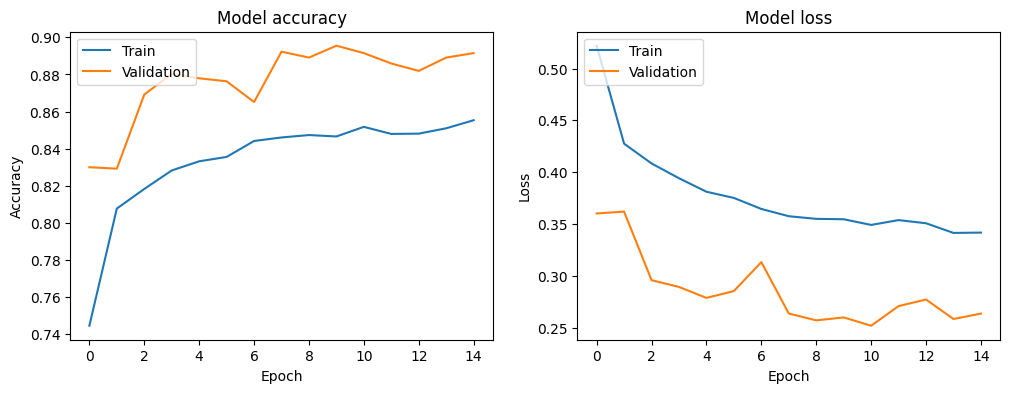

In [ ]:
def plot_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

# Plot the training history
plot_history(history)


In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

20/20 [==============================] - 2s 78ms/step - loss: 0.2603 - accuracy: 0.8962
Test accuracy: 0.8961661458015442
Test loss: 0.26033949851989746


20/20 [==============================] - 1s 63ms/step


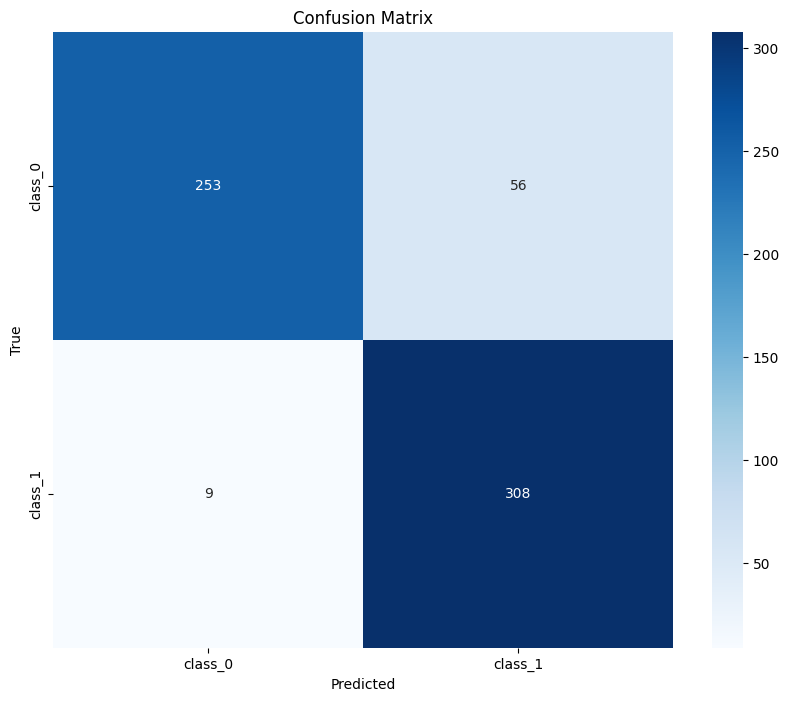

              precision    recall  f1-score   support

     class_0       0.97      0.82      0.89       309
     class_1       0.85      0.97      0.90       317

    accuracy                           0.90       626
   macro avg       0.91      0.90      0.90       626
weighted avg       0.91      0.90      0.90       626



In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Get true labels and predictions
true_labels = test_generator.classes
predictions = model.predict(test_generator)
predicted_labels = np.round(predictions).astype(int).flatten()

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

plot_confusion_matrix(cm, class_names)

# Print classification report
print(classification_report(true_labels, predicted_labels, target_names=class_names))


20/20 [==============================] - 1s 48ms/step


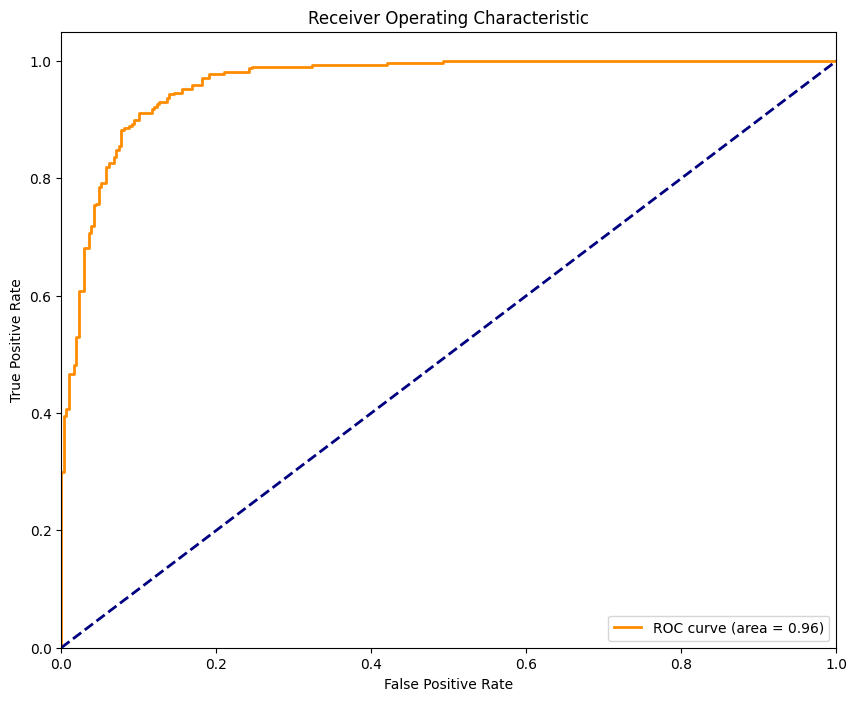

In [ ]:
# Function to plot roc curve
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(true_labels, predicted_probs):
    fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Compute predicted probabilities
predicted_probs = model.predict(test_generator).flatten()

# Plot ROC curve
plot_roc_curve(true_labels, predicted_probs)


1/1 [==============================] - 2s 2s/step


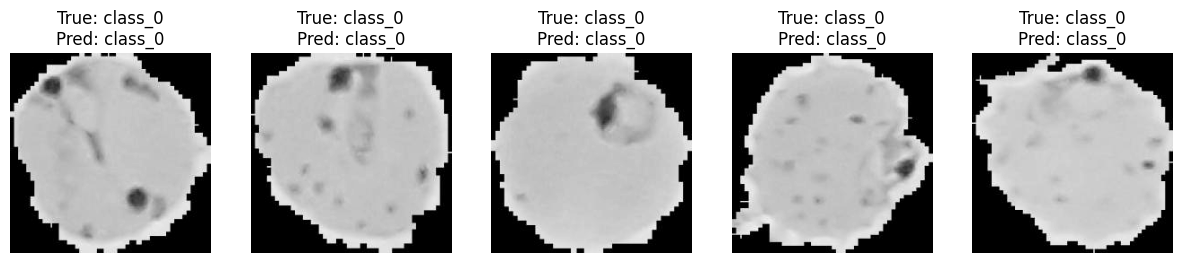

In [ ]:
# Function to visualize predictions
def visualize_predictions(generator, model, class_names, num_images=5):
    # Get a batch of images and labels
    images, labels = next(generator)

    # Get predictions for the batch
    predictions = model.predict(images)
    predicted_labels = np.round(predictions).astype(int).flatten()

    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i].reshape(224, 224), cmap='gray')  # Assuming grayscale images
        true_label = class_names[int(labels[i])]
        predicted_label = class_names[predicted_labels[i]]
        plt.title(f'True: {true_label}\nPred: {predicted_label}')
        plt.axis("off")

# Visualize predictions from the test dataset
visualize_predictions(test_generator, model, class_names, num_images=5)

In [ ]:
# Save model
model.save('/content/drive/MyDrive/mobilenetv2_malaria_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
